In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, r2_score, mean_absolute_error, mean_squared_error, confusion_matrix, ConfusionMatrixDisplay

# Лабораторная №1 - Проведение исследований с алгоритмом KNN

## 1.Выбор начальных условий

In [7]:
pd.options.display.max_columns = None
data_classification = pd.read_csv('class_data/stackoverflow_full.csv').drop('Unnamed: 0', axis=1) #Выгрузка csv с данными классификации

files = ['FOOD-DATA-GROUP1.csv', 'FOOD-DATA-GROUP2.csv', 'FOOD-DATA-GROUP3.csv', 'FOOD-DATA-GROUP4.csv', 'FOOD-DATA-GROUP5.csv']
data_reg = pd.concat((pd.read_csv(f'reg_data/{f}') for f in files), ignore_index=True).drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1) #объединение и выгрузка сразу всех файлов с данными регрессии

Для оценки качества Классификации будем использовать такие базовые метрики как: 
- Accuracy (Процент правильных предсказаний)
- F1-Score (важная метрика если классы несбалансированны)
- Confusion Matrix (Матрица которая покажет полную карту в работе модели)

Для оценки качества Регрессии будем использовать такие базовые метрики как:

- RMSE (показывает типичный размер ошибки в исходных единицах) 
- MAE (устойчива к выбросам)
- R^2 (показывает общее качество модели)

## 2.Создание бейзлайна и оценка качества

Перед созданием и обучением модели, нам надо немного почистить и закодировать данные в датафрейме Классификации, тк модель не сможет работать с object признаками. Датафрейм регрессии уже готов для обучения модели.

In [9]:
# Функция для кодирования данных для минимальной работоспособности модели
def encoder_data(data: pd.DataFrame):
    #Создаём энкодеры для работы с признаками
    onehot = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
    Ordinal = OrdinalEncoder()
    
    # Преобразуем признак HaveWorkedWith
    if 'HaveWorkedWith' in data.columns:
        tech_dummies = data['HaveWorkedWith'].str.get_dummies(sep=';')
        data = pd.concat([data, tech_dummies], axis=1)
        data = data.drop('HaveWorkedWith', axis=1)
    
    categorical_features = data.select_dtypes(include=['object']).columns
    for col in categorical_features:
        
        #Если признак бинарный используем OneHotEncoder
        if data[col].nunique() == 2:
            col_encoded = onehot.fit_transform(data[[col]])
            col_df = pd.DataFrame(col_encoded, columns=onehot.get_feature_names_out([col]))
            data = pd.concat([data.drop(col, axis=1), col_df], axis=1)
            
        #Если признак не бинарный используем OrdinalEncoder
        else:
            col_encoded = Ordinal.fit_transform(data[[col]])
            col_df = pd.DataFrame(col_encoded, columns=Ordinal.get_feature_names_out([col]))
            data = pd.concat([data.drop(col, axis=1), col_df], axis=1)
    return data

data_classification_encoded = encoder_data(data_classification)

После всей кодировки данных перейдём к обучению моделей. Разделим данные на тренировочные и тестовые для обучения и проверки метрик на данных которые модель ещё не видела и приступим к обучению

In [11]:
y_classification = data_classification_encoded['Employed']
x_classification = data_classification_encoded.drop('Employed', axis = 1)

y_reg = data_reg['Nutrition Density']
x_reg = data_reg.drop(['Nutrition Density','food'], axis=1)

x_classification = x_classification.astype(float)
x_reg = x_reg.astype(float)

X_train_classification, X_test_classification, y_train_classification, y_test_classification = train_test_split(x_classification, 
                                                                                                                y_classification, 
                                                                                                                test_size=0.33, 
                                                                                                                random_state=42) # разделение данных на тестовые и обучающие выборки

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(x_reg, 
                                                                    y_reg, 
                                                                    test_size=0.33, 
                                                                    random_state=42)

classification_model = KNeighborsClassifier() #модель KNN для классификации
Reg_model = KNeighborsRegressor() #Модель KNN для Регрессии

classification_model_fit = classification_model.fit(X_train_classification, y_train_classification) # обучение модели Классификации
Reg_model_fit = Reg_model.fit(X_train_reg, y_train_reg) # Обучение модели Регрессии

classification_predict = classification_model_fit.predict(X_test_classification) # Предсказываем для дальнейшего просмотра метрик
reg_predict = Reg_model_fit.predict(X_test_reg)

После обучения моделей выведем все метрики и оценим качество работы

Метрики KNN классификации: 
Accuracy - 0.641999752505878 
f1 - 0.6709882861366997



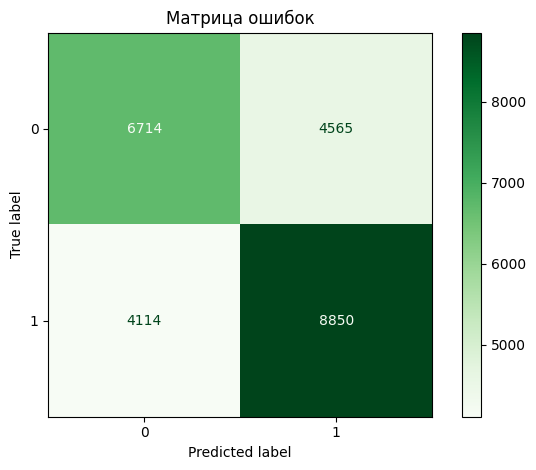

In [13]:
def metrics_class(true, predict):
    print(f'Метрики KNN классификации: \n'
          f'Accuracy - {accuracy_score(true, predict)} \n'
          f'f1 - {f1_score(true, predict)}\n')

    matrix = confusion_matrix(true, predict)
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
    disp.plot(cmap='Greens', values_format='d')
    plt.title('Матрица ошибок')
    plt.tight_layout()
    plt.show()

metrics_class(y_test_classification, classification_predict)

##### Метрики для бинарной классификации оказались следующими:
- Accuracy - 0.64 это неплохой результат для голой и лёгкой модели, такой как KNN. Данный результат показывает, что наша модель оказалась права в 64% случаев предсказывания
- f1 - 0.67 также неплохой результат для такой слабой модели. Данная метрика показывает среднее гармоническое между precision (точность) и recall (полнота)
##### Так же выведена матрица ошибок, на которой заметно, что наша модель примерно в одинаковых случаях ошибается на обоих метках.

In [15]:
def metric_reg(true, predict):
        print(f'Метрики KNN регрессии: \n'
          f'MAE - {mean_absolute_error(true, predict)} \n'
          f'R^2 - {r2_score(true, predict)}\n'
          f'RMSE - {np.sqrt(mean_squared_error(true, predict))}\n')
metric_reg(y_test_reg, reg_predict)

Метрики KNN регрессии: 
MAE - 23.114012895069536 
R^2 - 0.8310486179609027
RMSE - 63.000909261292676



Метрики для регрессии оказались следующими:
- MAE - 23.1 означает, что средняя ошибка составляет 23 единицы, что является хорошим результатом, ведь целевая переменная варируется от 0 до 500
- R² - 0.831 модель объясняет 83.1% дисперсии целевой переменной. Значения > 0.8 считаются отличными для большинства практических задач
- RMSE - 63.00 стандартное отклонение ошибок 63 единицы (~21% от диапазона). Такая разница между RMSE и MAE указывает на наличие выбросов в ошибках

## 3.Улучшение бейзлайна

В даннорм задание посмотрим более внимательно на целевую переменную. 
- Нет ли в данных пропусков
- удалим дубликаты если они есть
- проверим на дисбаланс целевой переменной для работы с классификацией
- сделаем проверку на выбросы в работе в регрессией
- Выведем график корреляции и ковариации признаков с целевой переменной
- Так же обязательно стоит привести все данные к одному диапозону значений, проскалировать их, тк многие модели работают на метриках расстояния данных.
- Построим графики важных, интересных признаков
- применим кросс-валидацию к модели и подберём к ней гиперпараметры через GridSreachCV.

### Проверка на пропуски

In [20]:
# Проверим пропуски
print(f'Пропуски в классификации:\n{data_classification.isna().sum().sum()}, {data_classification.columns[data_classification.isnull().any()].tolist()}')
print(f'Пропуски в регрессии:\n{data_reg.isna().sum().sum()}, {data_reg.columns[data_reg.isnull().any()].tolist()}')

Пропуски в классификации:
63, ['HaveWorkedWith']
Пропуски в регрессии:
0, []


Пропуски имеются только в Классификации, а именно 63 пропуска в признаке HaveWorkedWith, это очень маленькое значение в сравнении со всей выборкой. Они лишь означают, что человек не обладает никаким из технологий.

### Проверка ну дупликаты в данных

In [23]:
print(f'Кол-во дубликатов в Классификации: {data_classification.duplicated().sum()}')
print(f'Кол-во дубликатов в Регрессии: {data_reg.duplicated().sum()}')

Кол-во дубликатов в Классификации: 4
Кол-во дубликатов в Регрессии: 0


Дубликаты в данных классификации это нормально, это лишь говорит о том, что есть люди с такими же навыками, стеком технологий и из той же страны. В данных с регрессией же нету никаких дубликатов.

### Проверка целевой переменной на дисбаланс (Классификация) и выбросы (Регрессия)

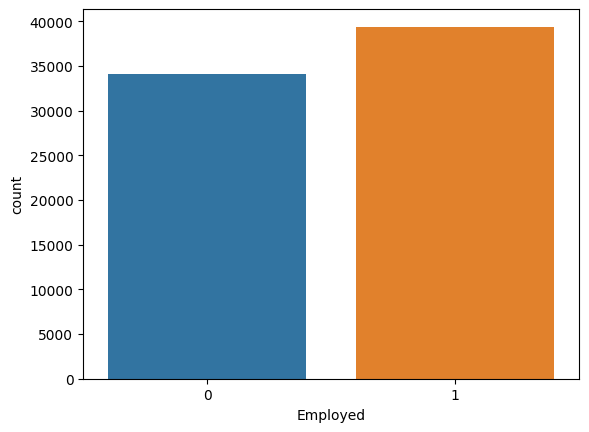

In [26]:
#Посмотрим на баланс бинарной целевой переменной
sns.countplot(data=data_classification, x='Employed')
plt.show()

На графике заметно, что бинарная целевая переменная не является идеально сбалансированной, а имеет разницу +-5000. Это не такое сильное значение, чтобы сильно о нём переживать

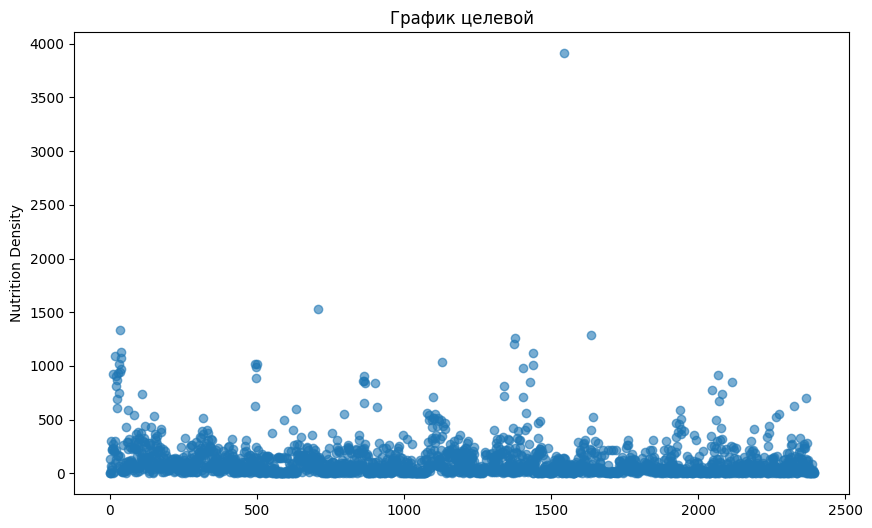

Самое высокое значение целевой: ['acerola cherry juice' 3911.4]


In [28]:
# Посмотрим на распределение непрерывной целевой переменной
plt.figure(figsize=(10, 6))
plt.scatter(data_reg.index, data_reg['Nutrition Density'], alpha=0.6)
plt.title('График целевой')
plt.ylabel('Nutrition Density')
plt.show()

max_target_food = data_reg['Nutrition Density'].max()
print('Самое высокое значение целевой:', data_reg[data_reg['Nutrition Density'] == max_target_food][['food','Nutrition Density']].values[0])

Из графика видно, что у нас есть один существенно высокий выброс, а именно это Сок Ацеролы с содержанием Плотности питательных веществ в 3911.4. Хоть это и выброс, это важная информация которую мы не можем просто так выбросить.

### Корреляция признаков в данных

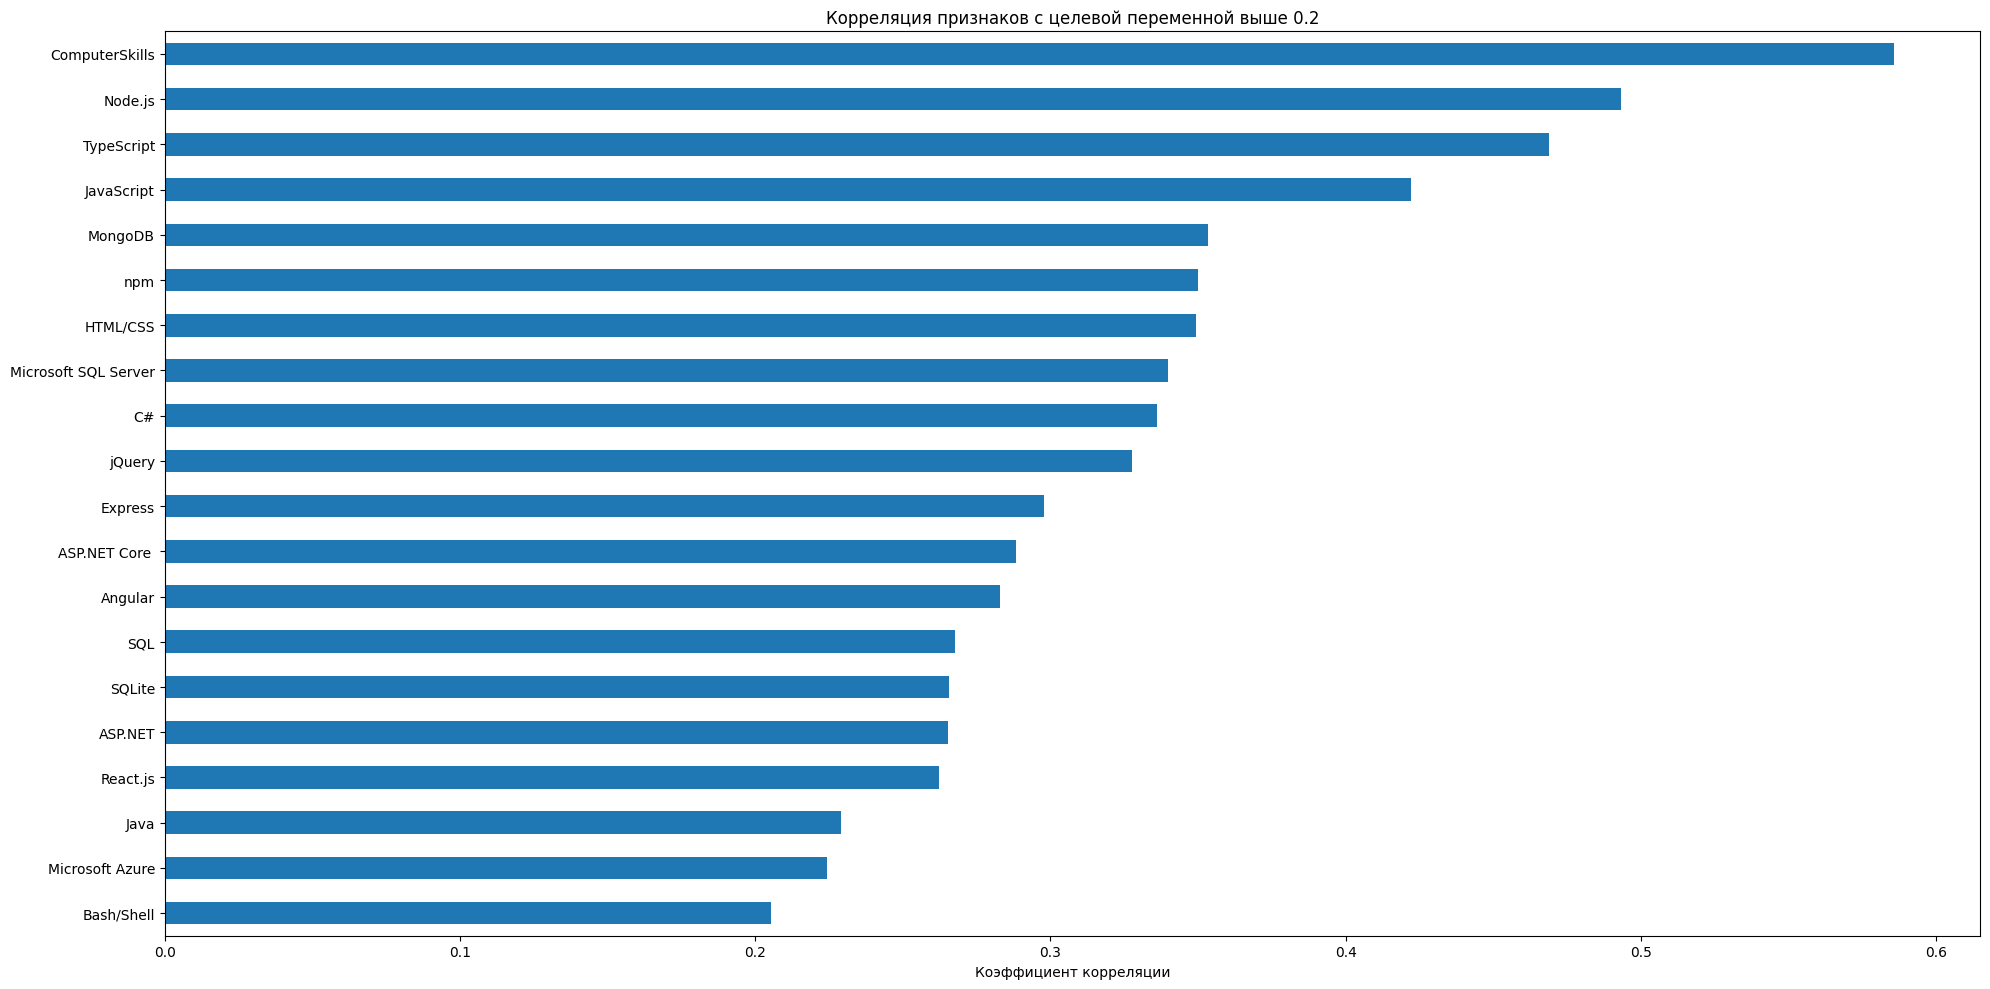

In [31]:
# выведем график корреляции с целевой переменной в классификации
target_corr = data_classification_encoded.corr()['Employed'].drop('Employed')
filter_corr = target_corr[target_corr.abs() >= 0.2].sort_values()

plt.figure(figsize=(20, 10))
filter_corr.sort_values().plot(kind='barh')
plt.title('Корреляция признаков с целевой переменной выше 0.2')
plt.xlabel('Коэффициент корреляции')
plt.tight_layout()
plt.show()

На данном графике видно, что выше всего влияет на целевую аудиторию ComputerSkills, владение Node.js, TypeScript и JavaScript, что говорит о высокой значимости в умении обращаться с данными технологиями для работодателя.

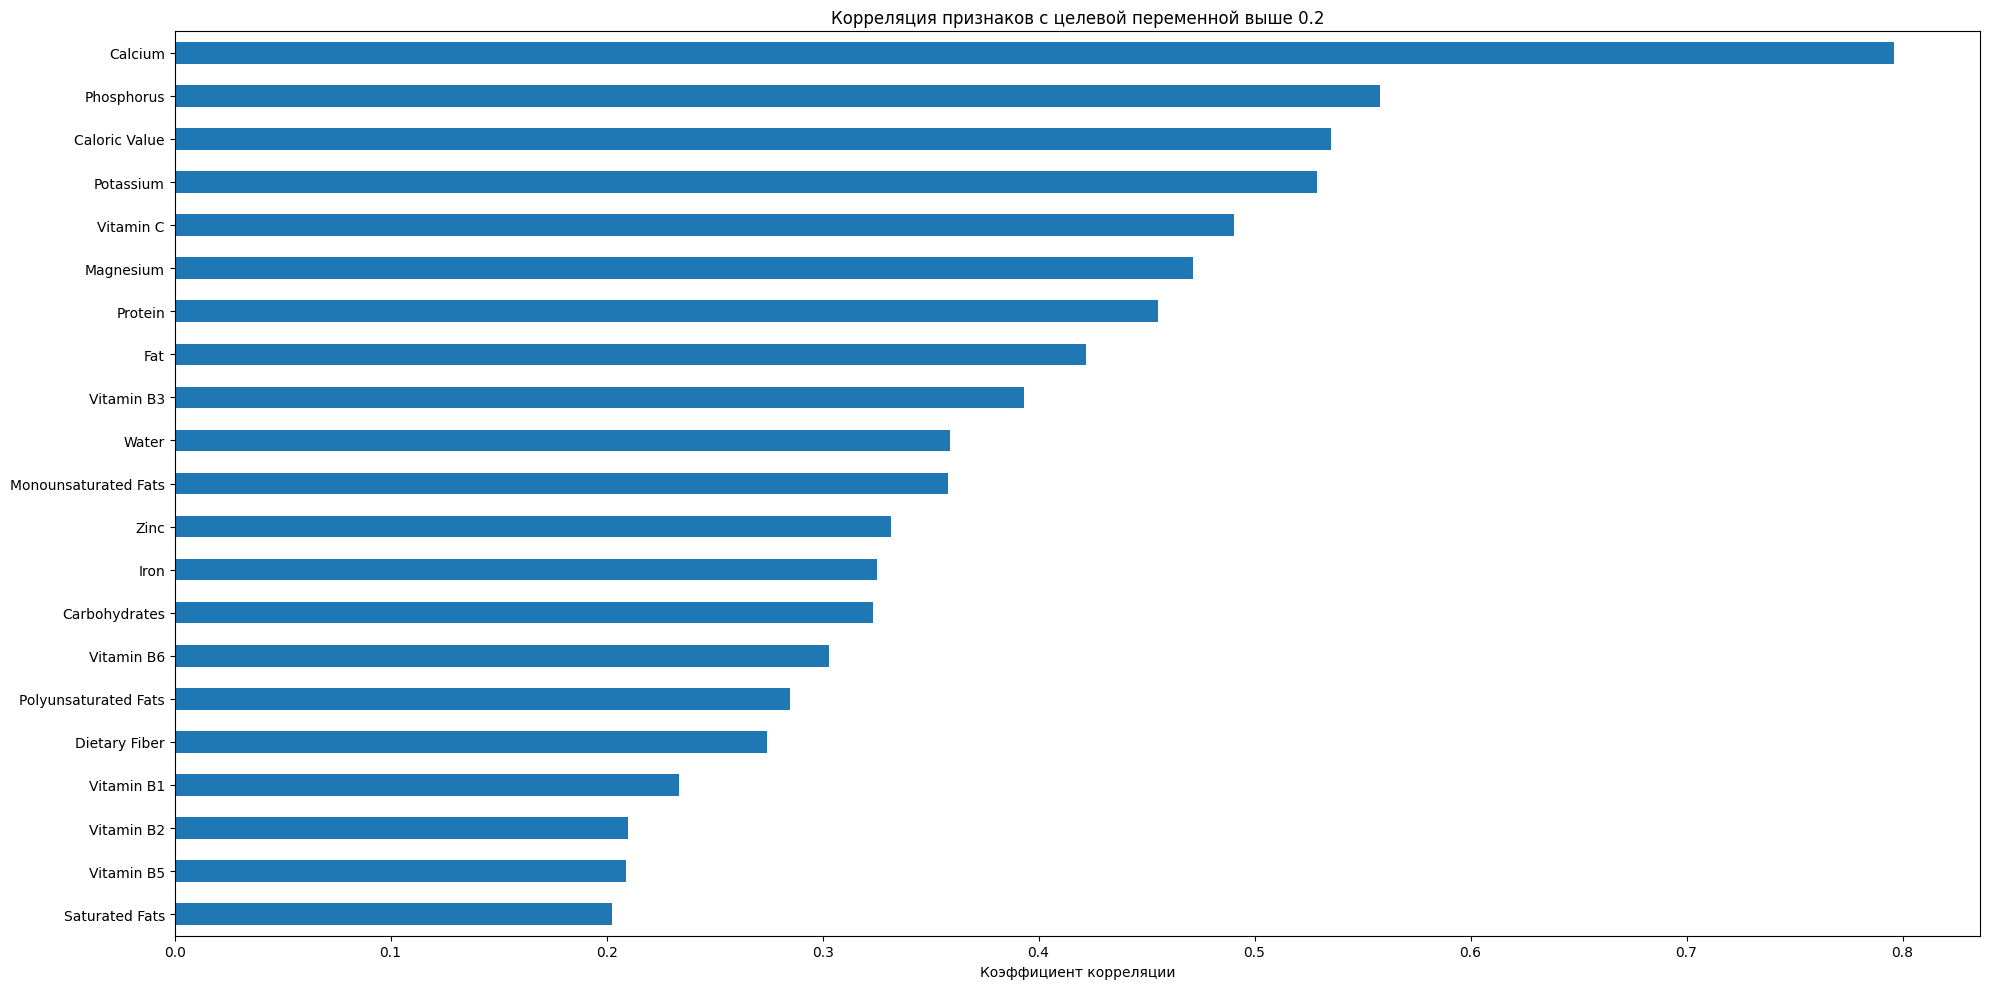

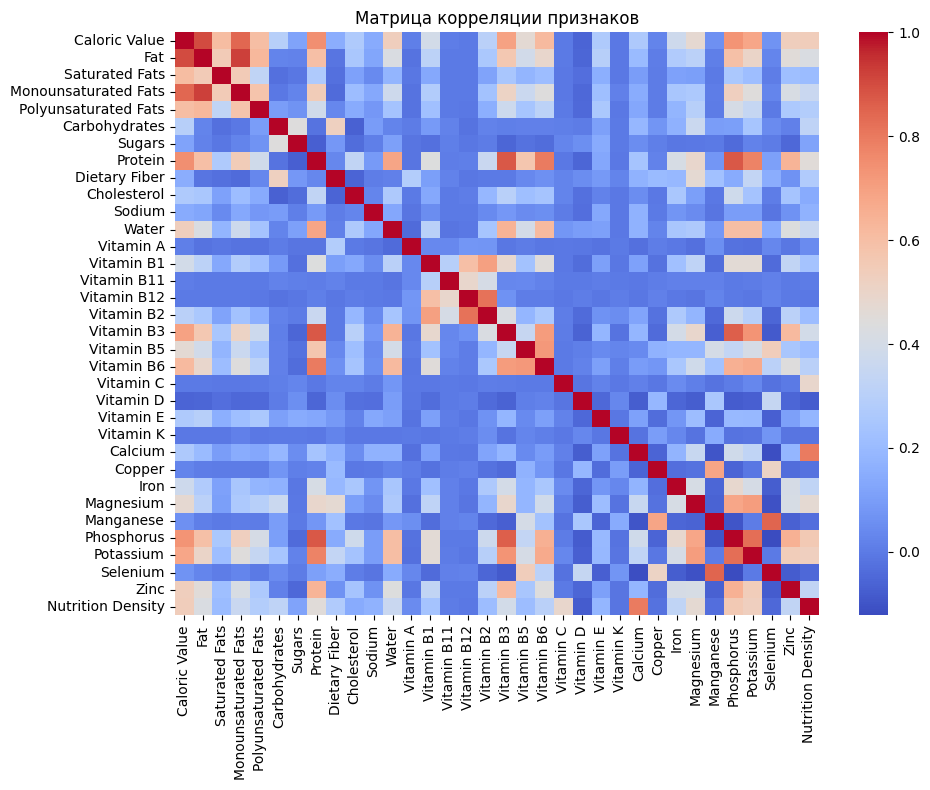

In [33]:
# Выведем полную матрицу корреляцию и график корреляции признаков с целевой переменной для регрессии

target_corr = data_reg.drop('food', axis=1).corr()['Nutrition Density'].drop('Nutrition Density')
filter_corr = target_corr[target_corr.abs() >= 0.2].sort_values()

plt.figure(figsize=(20, 10))
filter_corr.sort_values().plot(kind='barh')
plt.title('Корреляция признаков с целевой переменной выше 0.2')
plt.xlabel('Коэффициент корреляции')
plt.tight_layout()
plt.show()

corr_matrix = data_reg.drop('food', axis=1).corr()
plt.figure(figsize=(10,8))
heatmap=sns.heatmap(corr_matrix, cmap='coolwarm')
plt.title('Матрица корреляции признаков')
plt.tight_layout()
plt.show()

В важностях признаков видно, что больше всего на питательность влияет Calcium (Кальций), почти 0.8 корреляция с целевой переменной, что является превосходнейшим показателем. Есть так же три признака, что выше 0.5, а именно Phosphorus (Фосфор), Количество каллорий и Potassium (Калий). Матрица же корреляций здесь для того, чтобы обнаружить в случае чего Мультиколлинеарность в данных, это может плохо сказаться на стабильности оценки коэффициентов, становится трудно понять вклад каждого признака в целевую, признаки могут казаться статистически незначемыми, даже если они важны. В данной матрице подозрительно выглядят признаки Жирности пищи Fat и кол-во каллорий в ней. Лучше удалим их из Данных если модель будет слишком хорошо себя показывать, тк Caloric Values имеет хорошую корреляцию с целевой, и ещё большую с Fat признаками.

Построим график и посмотрим более внимательно на зависимость целевой переменной от Кальция, может найдём там чего интересное

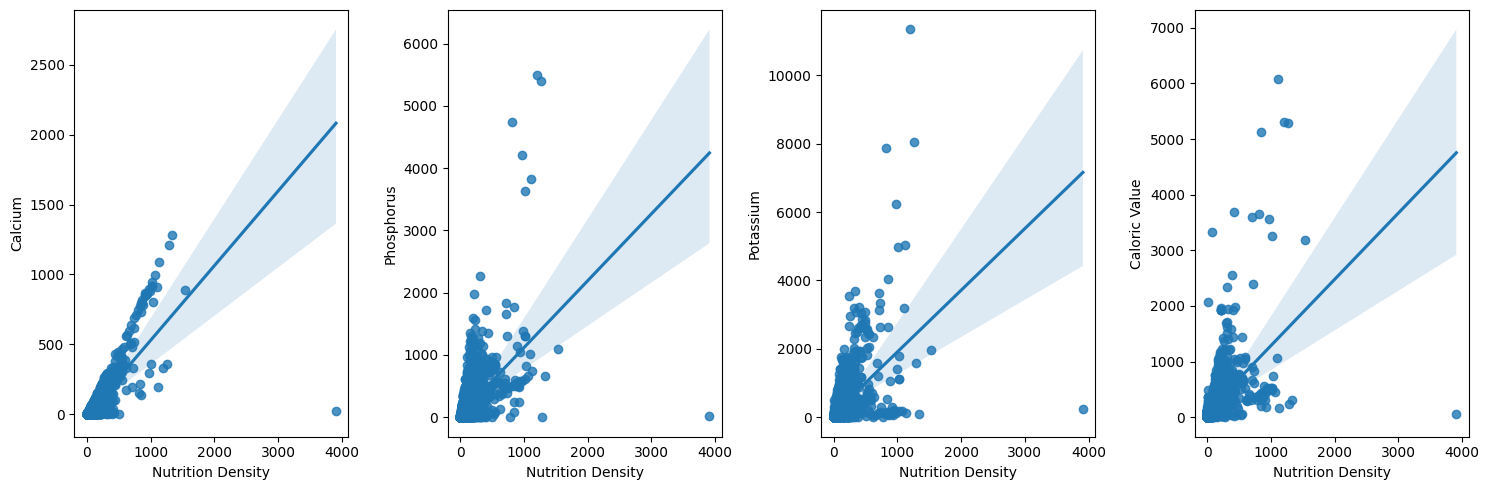

In [36]:
features = ['Calcium', 'Phosphorus', 'Potassium', 'Caloric Value']

fig, axes = plt.subplots(1, 4, figsize=(15, 5))

# Просто вызываем regplot для каждого признака
sns.regplot(x=data_reg['Nutrition Density'], y=data_reg[features[0]], ax=axes[0])
sns.regplot(x=data_reg['Nutrition Density'], y=data_reg[features[1]], ax=axes[1]) 
sns.regplot(x=data_reg['Nutrition Density'], y=data_reg[features[2]], ax=axes[2])
sns.regplot(x=data_reg['Nutrition Density'], y=data_reg[features[3]], ax=axes[3])

plt.tight_layout()
plt.show()

Построили 4 графика для просмотра линейной зависимости между целевой переменной и 4 самыми высокими переменными по Корреляции. Самая сильная зависимость видна в первом графике, в других она более слабо заметна. Скорее всего Линейные модели, такие как к примеру Линейная регрессия хорошо себя покажут на этих данных

### Применим Scaler к данным и найдём гиперпараметры модели с кросс-валидацией

In [39]:
scaler_class = StandardScaler()
scaler_reg = StandardScaler()

X_train_classification_scaled = scaler_class.fit_transform(X_train_classification) 
X_test_classification_scaled = scaler_class.transform(X_test_classification)

X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
X_test_reg_scaled = scaler_reg.transform(X_test_reg)

Использовали StandartScaler на данных именно после train_test_split чтобы не произошло утечки данных в тестовую выборку. Далее подберём гиперпараметры к моделям с кросс-валидацией

Параметры для KNN:
- n_neighbors - Количество соседей для голосования
- weights - разница весов соседей в зависимости от голосования
- metric - По какой формуле будем считать расстояние

In [42]:
params_class = {
    'n_neighbors': range(3, 15),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

params_reg = {
    'n_neighbors': range(3, 15),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

model_class = KNeighborsClassifier()
grid_class = GridSearchCV(estimator=model_class, param_grid=params_class, cv=8)

model_reg = KNeighborsRegressor()
grid_reg = GridSearchCV(estimator=model_reg, param_grid=params_reg, cv=8)

KNN_class = grid_class.fit(X_train_classification_scaled, y_train_classification)
KNN_reg = grid_reg.fit(X_train_reg_scaled, y_train_reg)

Метрики KNN классификации: 
Accuracy - 0.8421812481953553 
f1 - 0.8329695276346809



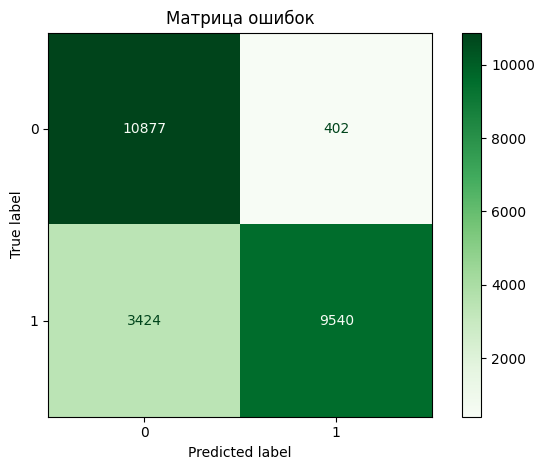

Метрики KNN регрессии: 
MAE - 23.206604206015474 
R^2 - 0.8222226240924393
RMSE - 64.62554057201366



In [43]:
predict_class = KNN_class.predict(X_test_classification_scaled)
predict_reg = KNN_reg.predict(X_test_reg_scaled)

metrics_class(y_test_classification, predict_class)
metric_reg(y_test_reg, predict_reg)

После обучения модели по новому бейзлайну, можно заметить характерное улучшение метрик в классификации.
- Accuracy - 0.84 (На 0.2 больше базового бейзлайна, что является превосходным результатом)
- f1 - 0.83 (F1 скор так же сильно поднялся, теперь наша модель работает ещё лучше)
- По матрице ошибок можно заметить, что мы ошиблись всего лишь 402 раза в 0 и 3424 в 1, но видим прекрасный результат всё равно.

В обучении модели Регрессии явного прогресса незаметно, но модель всё равно показывает себя хорошо.
- MAE - 23.2 (Средняя ошибка в 23.2 это неплохо, ведь наша целевая в среднем идёт от 0 до 500)
- R^2 - 0.82
- RMSE - 64.6

# 4.Имплементация алгоритма машинного обучения 

Создадим свой собественный класс KNN и проведём с ним те же исследования, обучим на базовом бейзлайне и новом бейзлайне. Будем создавать один класс для обеих задач и уже в нём решать, какую именно задачу мы решаем.

In [48]:
class KNN:
    def __init__(self, k=3, mode="classification"):
        self.k = k
        self.mode = mode

    def _to_numpy(self, X):
        # Если это DataFrame или Series → берём только числовые столбцы
        if isinstance(X, (pd.DataFrame, pd.Series)):
            X = X.select_dtypes(include=[np.number])
        return np.asarray(X, dtype=float)

    def fit(self, X, y):
        self.X = self._to_numpy(X)
        self.y = np.array(y, dtype=float if self.mode == "regression" else object)

    def _distance(self, a, b):
        return np.sqrt(np.sum((a - b) ** 2))

    def _get_neighbors(self, x):
        distances = np.linalg.norm(self.X - x, axis=1)
        idx = distances.argsort()[:self.k]
        return self.y[idx]

    def predict_one(self, x):
        x = self._to_numpy(x).reshape(1, -1)
        neighbors = self._get_neighbors(x)

        if self.mode == "classification":
            return Counter(neighbors).most_common(1)[0][0]
        else:
            return np.mean(neighbors)

    def predict(self, X):
        X = self._to_numpy(X)
        return np.array([self.predict_one(x) for x in X])

Далее обучим наши модели для обоих задач, предскажем и посмотрим метрики, сравнив их с прошлыми результатами.

In [50]:
Our_knn_class_model = KNN(mode='classification')
Our_knn_reg_model = KNN(mode='regression')

Our_knn_class_model.fit(X_train_classification, y_train_classification)
Our_knn_reg_model.fit(X_train_reg, y_train_reg)

Метрики KNN классификации: 
Accuracy - 0.6489295879222868 
f1 - 0.674145258241127



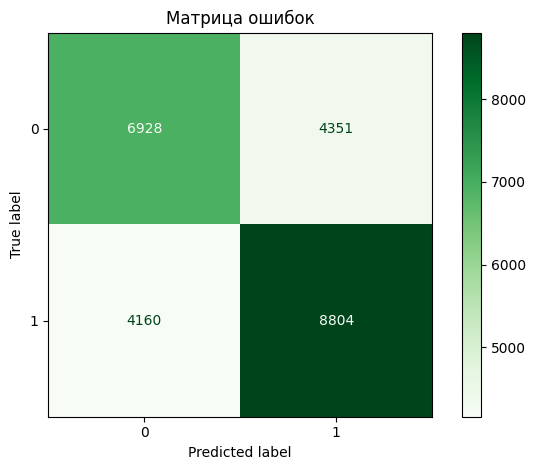

Метрики KNN регрессии: 
MAE - 22.139610198061526 
R^2 - 0.8434403927045666
RMSE - 60.64650874355416



In [51]:
pred_class = Our_knn_class_model.predict(X_test_classification)
pred_reg = Our_knn_reg_model.predict(X_test_reg)

metrics_class(y_test_classification, pred_class)
metric_reg(y_test_reg, pred_reg)

Метрики для Классификации:
- Accuracy - 0.648, это на 0.007 больше чем модель для базового бейзлайна модели из Sklearn, изменений практически нет
- f1 - 0.674, на 0.004 больше чем модель Sklearn, изменений так же практически не имеется

Метрики Регрессии:
- MAE - 22.13 на единицу меньше, результат стал лучше, но так-же незначительно
- R^2 - 0.84 на процент выше базовой модели sklearn
- RMSE - 60.64 измненеия так же незначительно, на 2.6 меньше

Далее проверим модель на новом бейзлайне с применением масштабирования данных, подбором гиперпараметров и применением кросс-валидации. Для найдём наилучешия значения гиперпараметров

In [55]:
print(f'Лучшие параметры для задачи регрессии:{grid_class.best_params_}')
print(f'Лучшие параметры для задачи Классификации:{grid_reg.best_params_}')

Лучшие параметры для задачи регрессии:{'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'distance'}
Лучшие параметры для задачи Классификации:{'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}


Метрики KNN классификации: 
Accuracy - 0.7893000041249021 
f1 - 0.7734610608479688



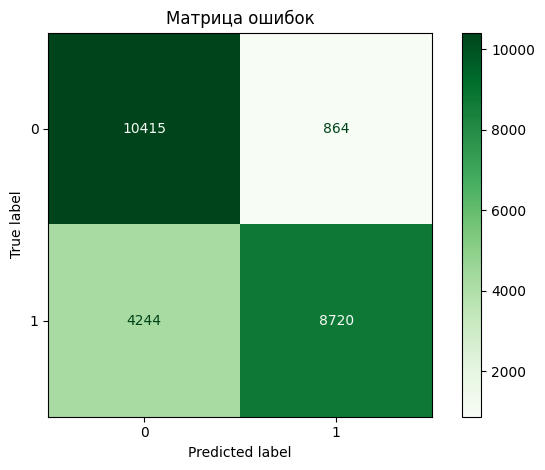

Метрики KNN регрессии: 
MAE - 27.91360834386852 
R^2 - 0.7692373966739001
RMSE - 73.62895861462327



In [58]:
class_model_second = KNN(k=3, mode='classification')
class_model_second.fit(X_train_classification_scaled, y_train_classification)

reg_model_second = KNN(k=10, mode='regression')
reg_model_second.fit(X_train_reg_scaled, y_train_reg)

predict_reg = reg_model_second.predict(X_test_reg_scaled)
predict_class = class_model_second.predict(X_test_classification_scaled)

metrics_class(y_test_classification, predict_class)
metric_reg(y_test_reg, predict_reg)

Метрики для нашей KNN классификация в новом бейзлайне:
- Accuracy - 0.789 Заметные заметные улучшения с базовым бейзлайном, но это отстатёт на целых 0.05 от Улучшенного бейзлайна с моделью sklearn
- f1 - 0.77 Здесь всё так же как и с Accuracy.

Метрики для нашей KNN регрессии в новом бейзлайне:
- MAE - 27.91
- R^2 - 0.76 
- RMSE - 73.62
##### В новом бейзлайне модель стала работать даже хуже в регрессии и этим метрики немного хуже чем модель в новом бейзлайне из модели sklearn

# Вывод по проделанной работе

В ходе лабораторной работы мы учились работать с такой моделью как KNN (Модель ближайших соседей). Мы работали с двумя датасетами на Регрессию - Датасеб об питательности различных продуктов и на Классификацию - Датасет об кандидатах на работу и их навыки. Мы обучали модели 4 раза, первый раз базовая модель из sklearn без особой обработки данных (только кодировка для банальной работы модели), далее с улучшенным бейзлайном, применили масштабирование к данным, провели поиск оптимальных гиперпараметров и применили CV к моделям. В данных классификации наилучшим себя показала модель из sklearn в улучшеном бейзлайне, а в регрессии наша самодельная модель и базовым бейзлайном. Так же в ходе работе проведена полная аналитика наших данных, для дальнейшего понимания как лучше работать с ними и что лучше принять, использовать это будем так же в будущих лабораторных работах.